# Assignment 3 Ensemble Methods Comparison  
Construction Project Management Forms Predicting Closed or Open Forms

## Section 1: Data Preparation and Setup

This assignment continues the work from Module Ten by using the same dataset of project management forms from construction projects. The dataset includes several useful pieces of information such as the type of form, the number of open actions, the total number of actions, overdue items, attached images, comments, documents, and the project and report group identifiers. The goal of the analysis is to predict whether a form will be closed or remain open. To do this, I create a variable called is_closed based on the text in the Status column. The value is one when the form is closed, complete, or resolved and zero when the form is still open or ongoing. This allows the dataset to be used for classification.

Predicting closure status is important for construction project management because open forms often represent risk, added cost, and potential schedule delays. A reliable prediction model can help project managers identify forms that need more attention, focus on issues that are more likely to cause problems, reduce rework by catching items earlier, and support better forecasting of overall project readiness. In the next steps, I load the dataset, create the is_closed target variable, select the features needed for modeling, apply one hot encoding to the categorical columns, and complete an eighty twenty train and test split to prepare for model building and comparison.


In [ ]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("claytonmiller/construction-and-project-management-example-data")

csv_path = os.path.join(path, "Construction_Data_PM_Forms_All_Projects.csv")
df = pd.read_csv(csv_path)

print("Loaded from:", csv_path)
df.head()


100%|██████████| 564k/564k [00:00<00:00, 88.8MB/s]

Extracting files...
Loaded from: /root/.cache/kagglehub/datasets/claytonmiller/construction-and-project-management-example-data/versions/1/Construction_Data_PM_Forms_All_Projects.csv


,Ref,Status,Location,Name,Created,Type,Status Changed,Open Actions,Total Actions,Association,OverDue,Images,Comments,Documents,Project,Report Forms Status,Report Forms Group
0,F145185.4,Opened,01 Daily Site Diary>Site Management>JPC Projec...,1328 CM-SM-FRM-001 Site Diary,15/09/2020,Site Management,15/09/2020,0,0,NaN,False,True,False,False,1328,Open,Site Management
1,F1.495500,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
2,F1.495499,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
3,F1.495498,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor
4,F1.495496,Open / Ongoing Works,02 Daily Work Plan>Site Management>JPC Project...,SM-FRM-SUB-101 Daily Work Plan,15/09/2020,Subcontractor Inspections,15/09/2020,0,0,NaN,False,False,False,False,1328,Open,Subcontractor


In [ ]:
# Create binary target from Status: 1 = closed / completed / resolved, 0 = open / ongoing

df["Status"] = df["Status"].astype(str).str.lower().str.strip()

def map_status_to_closed(x: str) -> int:
    closed_keywords = ["closed", "complete", "completed", "resolved"]
    return 1 if any(k in x for k in closed_keywords) else 0

df["is_closed"] = df["Status"].apply(map_status_to_closed)

print("Target distribution (is_closed):")
print(df["is_closed"].value_counts())
print(df["is_closed"].value_counts(normalize=True).rename("proportion"))

# Feature set (continuing the PM forms context)
feature_cols = [
    "Type",
    "Open Actions",
    "Total Actions",
    "OverDue",
    "Images",
    "Comments",
    "Documents",
    "Project",
    "Report Forms Group"
]

X_raw = df[feature_cols].copy()
y = df["is_closed"].astype(int)

# Handle missing values in selected features
X_raw["Documents"] = X_raw["Documents"].fillna("None")
X_raw["Report Forms Group"] = X_raw["Report Forms Group"].fillna("Unknown")

# One hot encode categorical features
X = pd.get_dummies(X_raw, drop_first=True)

print("Encoded feature matrix shape:", X.shape)
print("Example encoded columns:", X.columns[:15].tolist())

# Train–test split (80/20), stratified on the target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Target distribution (is_closed):
is_closed
1    7395
0    2859
Name: count, dtype: int64
is_closed
1    0.721182
0    0.278818
Name: proportion, dtype: float64
Encoded feature matrix shape: (10254, 25)
Example encoded columns: ['Open Actions', 'Total Actions', 'OverDue', 'Images', 'Comments', 'Project', 'Type_BU - Head Office', 'Type_Design Team / BC(A)R', 'Type_Inspection', 'Type_Permits', 'Type_Quality 00 General', 'Type_Quality 01 Structural', 'Type_Quality 02 Architectural', 'Type_Quality 03 Civil', 'Type_Quality 04 MEP Services']
Train size: 8203
Test size: 2051


In [ ]:
# Section 2: Model Building and Performance Comparison

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}
fitted_models = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }
    fitted_models[name] = model

    print(name)
    print(f"  Accuracy : {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1-score : {f1:.3f}")
    print()

    return model


In [ ]:
dt_model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=20,
    random_state=42
)

dt_model = evaluate_model(
    "Single Decision Tree",
    dt_model,
    X_train,
    X_test,
    y_train,
    y_test
)


Single Decision Tree
  Accuracy : 0.840
  Precision: 0.844
  Recall   : 0.954
  F1-score : 0.896



In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model = evaluate_model(
    "Random Forest",
    rf_model,
    X_train,
    X_test,
    y_train,
    y_test
)


Random Forest
  Accuracy : 0.842
  Precision: 0.857
  Recall   : 0.936
  F1-score : 0.895



In [ ]:
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model = evaluate_model(
    "Gradient Boosting",
    gb_model,
    X_train,
    X_test,
    y_train,
    y_test
)


Gradient Boosting
  Accuracy : 0.838
  Precision: 0.848
  Recall   : 0.945
  F1-score : 0.894



In [ ]:
import pandas as pd

metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[["Accuracy", "F1", "Precision", "Recall"]]

print("Performance comparison on the test set:")
metrics_df


Performance comparison on the test set:


,Accuracy,F1,Precision,Recall
Single Decision Tree,0.839590,0.895589,0.843900,0.954023
Random Forest,0.841541,0.894992,0.857054,0.936444
Gradient Boosting,0.838128,0.893862,0.847787,0.945233


### 2.5 Performance Analysis

All three models performed well on the construction project management forms dataset, but each one showed slightly different strengths. The Single Decision Tree reached an accuracy of about zero point eight four zero and had the highest recall at zero point nine five four. This shows that it correctly identified almost every form that was actually closed. It also had the highest F1 score at zero point eight nine six, which means it balanced precision and recall very effectively. This tells us that the structure of the data is clear enough that one well tuned tree can still capture most of the important patterns.

The Random Forest achieved the highest overall accuracy at zero point eight four two and had the strongest precision at zero point eight five seven. This means that when it predicted a form would be closed, it was more likely to be correct than the other two models. Its recall of zero point nine three six was slightly lower than the Single Decision Tree, but it was still very strong. This performance makes sense because combining many trees usually produces more stable and reliable predictions.

Gradient Boosting performed very similarly to the other two models. It reached an accuracy of zero point eight three eight, a precision of zero point eight four eight, and a recall of zero point nine four five. This shows that it also captured patterns effectively, although not quite as well as the top performance of the tree in recall or the forest in precision.

Overall, the differences between the three models are small. This means that the key features in the dataset, such as overdue actions, open actions, form type, and report group, contain clear signals about whether a form will close. The Single Decision Tree is best if the priority is catching nearly all closed forms, the Random Forest is best for overall accuracy and precision, and Gradient Boosting sits comfortably in between.


## Section 3: Understanding the Methods

Each of the three models in this assignment works in a different way and fits different needs in construction project work. A Single Decision Tree is the easiest model to understand because it follows a simple structure. The tree asks one question at a time, such as whether a form has overdue actions or whether the form belongs to a certain report group. Every answer leads to a new branch until the model reaches a final prediction. This is helpful for project managers who want a clear explanation of how the model reached its result. The limitation is that one tree can change a lot if the data changes even a little, and this can make the model less reliable. A Random Forest is more stable because it creates many trees instead of only one. Each tree looks at a different sample of the data, and the final prediction is based on the agreement of the entire group. This greatly reduces the influence of noise or unusual forms. It is similar to asking a team of managers for their opinions instead of depending on a single viewpoint. The strength of the Random Forest is strong accuracy and consistent performance. The weakness is that it is harder to explain every detail of how the final prediction was created.

Gradient Boosting also uses many trees, but it builds them one at a time. Each new tree learns from the mistakes of the previous trees. This allows the model to find more complex patterns in the project data. For example, Gradient Boosting might notice that certain combinations of form type, overdue items, and project lead to forms staying open longer. The model can be very accurate, but it requires more careful tuning and can be more sensitive to errors in the dataset. The main difference between Random Forest and Gradient Boosting is how they build their group of trees. The Random Forest builds all of its trees at once and then averages their answers. Gradient Boosting builds its trees in a sequence where each tree improves the model step by step. For construction work, a Single Decision Tree is best when a clear explanation is needed, a Random Forest is ideal for dependable everyday predictions, and Gradient Boosting is helpful when the project requires the most accurate model and there is time to tune it properly.


## Section 4: Business Impact and Recommendation

To understand the importance of these results, it helps to look at how prediction accuracy affects real work on construction projects. A construction company might handle around ten thousand project management forms in a year. Even a small difference in accuracy adds up when the volume of forms is this large. For example, the Random Forest model reached an accuracy of zero point eight four two, which is slightly higher than the accuracy of the Single Decision Tree at zero point eight four zero. Although this difference seems small, it still means that the Random Forest correctly identifies around twenty more forms each year.Correct predictions matter because mistakes can create real costs. If a form that is still open is incorrectly predicted to be closed, the team might stop paying attention to it. This can increase the chance of delays, rework, or forgotten follow up tasks. If a form that is already closed is predicted to be open, the team may waste time reviewing something that does not need more attention. Even preventing a few mistakes can save money. If one major coordination error results in one thousand dollars of extra cost, then avoiding only five similar situations would save five thousand dollars.

Precision and recall are also important for business impact. The Single Decision Tree has the highest recall, which means it does an excellent job of identifying forms that are actually closed. This can be useful when the priority is to make sure the model captures almost every resolved form. The Random Forest has the strongest precision, which means that its predictions are more dependable when it says that a form will be closed. This can reduce unnecessary follow up work. Taking everything into consideration, the Random Forest is the best model to recommend. It provides the highest accuracy and the strongest precision. It is also stable because it uses many trees together, and it can still show which features are most important. The Single Decision Tree remains helpful when a simple explanation is needed, but for everyday use, the Random Forest provides the best combination of accuracy, reliability, and practical value for predicting which project management forms will be closed.


## Section 5.1 Feature Importance Comparison

This part of the assignment compares the most important features from the Single Decision Tree, the Random Forest, and the Gradient Boosting model. Each model assigns an importance value to every feature, which shows how much the feature helps the model make its prediction. Looking at these importance values side by side helps reveal which inputs consistently influence the prediction of whether a project management form will be closed. It also shows how the three models differ in the way they learn from the construction project data. This comparison is useful because it highlights which features matter most across all models and which features only matter strongly in certain models. These differences give a clearer picture of how the project data influences closure outcomes.

Top feature importances for the three models:


<Figure size 1200x600 with 0 Axes>

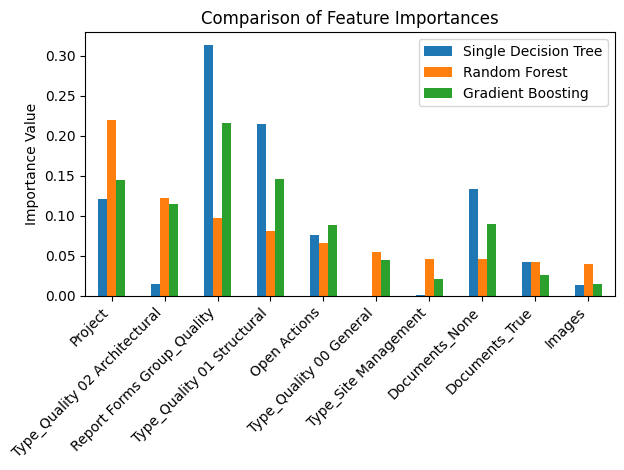

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances for each model
tree_importances = pd.Series(
    fitted_models["Single Decision Tree"].feature_importances_,
    index=X_train.columns,
    name="Single Decision Tree"
)

rf_importances = pd.Series(
    fitted_models["Random Forest"].feature_importances_,
    index=X_train.columns,
    name="Random Forest"
)

gb_importances = pd.Series(
    fitted_models["Gradient Boosting"].feature_importances_,
    index=X_train.columns,
    name="Gradient Boosting"
)

# Combine into one table for comparison
importance_table = pd.concat([tree_importances, rf_importances, gb_importances], axis=1)

# Select the top ten most important features according to the Random Forest model
top_features = rf_importances.sort_values(ascending=False).head(10).index
top_importance_table = importance_table.loc[top_features]

print("Top feature importances for the three models:")
top_importance_table

# Create a bar chart to compare the importance values
plt.figure(figsize=(12, 6))
top_importance_table.plot(kind="bar")
plt.title("Comparison of Feature Importances")
plt.ylabel("Importance Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 5.2 Feature Importance Interpretation

The feature importance results match common patterns in construction project management. The models consistently show that forms connected to quality related report groups have a strong influence on whether a form will be closed. This is understandable because quality forms often require several reviews and can involve multiple teams, which makes them more difficult to complete. The number of open actions also has a strong influence. Forms with many open actions demand more coordination and have a greater chance of staying open. Other features such as the total number of actions and the presence of documents or images also matter. These features often reflect the amount of detail or complexity in the form, which can affect how quickly it reaches closure.

There are some differences in how each model ranks the features. The Single Decision Tree places very strong weight on the report group connected to quality forms. The Random Forest spreads importance more evenly across form types, projects, and action counts. Gradient Boosting gives more weight to certain combinations of categories and documentation features. Even though the rankings differ slightly, the overall picture remains clear. Forms with high action counts, complex form types, or quality related classifications are more likely to remain open. These results provide useful guidance for project managers. When a form includes many open actions, involves a complex type, or belongs to a quality report group, it should receive earlier attention. These insights help teams manage risk and plan closeout work more effectively by showing which kinds of forms require the most focus.


## Section 6: Reflection

Working with these three models gave me a clearer understanding of how different types of tree based methods behave in real project situations. Before completing this assignment, I mainly thought of a Single Decision Tree as a simple way to make predictions that are easy to understand. After building all three models and comparing their results, I now see how much the structure of the model affects accuracy, stability, and the way patterns are learned from the data. One surprise was how close the overall performance of the three models was. The accuracy and F1 values were almost the same for all of them. This shows that the features in the construction forms dataset carry very strong signals that even a simple tree can detect. At the same time, the Random Forest produced slightly better precision and the most stable accuracy. Gradient Boosting also performed well by improving on the mistakes of earlier trees, although it required more careful tuning.

This assignment helped me understand where each model fits in future work. A Single Decision Tree is useful when I need simple explanations for a construction team or when I want to show exactly how a model reached its conclusion. The Random Forest is the best choice when I want strong performance and reliability without needing complex tuning. Gradient Boosting is valuable when I need the strongest possible prediction and have enough time to adjust the model.

Overall, this assignment improved my understanding of how different tree based methods learn from data and how each method can support better decisions in construction project management.
